In [1]:
import tensorflow as tf
from tensorflow.keras import layers as tl
from tensorflow.data import Dataset
import tensorflow_datasets as tfds
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

In [2]:
def diffusion_f(t, T, s):
    return np.cos((t / T + s) / (1 + s) * np.pi / 2) ** 2

def variance_schedule(T, s=0.008, max_beta=0.999):
    t = np.arange(T+1) # additional slot for t = 0 [0, 1, 2, ..., T]
    f = diffusion_f(t, T, s)  # [f(0), f(1), f(2), ..., f(T)]
    
    alpha = np.clip(f[1:]/f[:-1], 1 - max_beta, 1) # calculate alpha and clip the value for min: 1-max_beta, max: 1
    alpha = np.append(1, alpha).astype(np.float32) # insert alpha0
    beta = 1 - alpha
    alpha_overline = np.cumprod(alpha)

    return alpha, alpha_overline, beta

    
    

In [3]:
T = 500
alpha, alpha_overline, beta = variance_schedule(T)

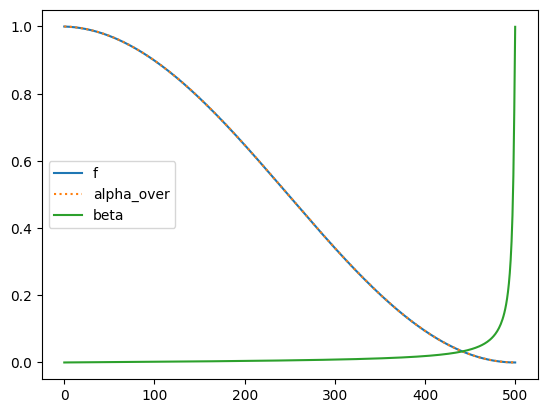

In [4]:
t = np.arange(T+1)

f = diffusion_f(t, T, 0.008)

plt.plot(t, f, label='f')
plt.plot(t, alpha_overline, label='alpha_over', linestyle=':')
plt.plot(t, beta, label='beta')
plt.legend()

plt.show()

In [5]:
tf.random.set_seed(int(datetime.now().timestamp()))
def prepare_batch_factory(T, alpha_overline):
    def prepare_batch(X): # values in X should be between 0 ~ 1
        X = X * 2 - 1  # X would be between -1 ~ 1 (similar to gauss normal distribution)
        X_shape = tf.shape(X)
        if len(X_shape) == 3:
            X = tf.cast(X[..., tf.newaxis], tf.float32) # new axis for channel layer
        else:
            X = tf.cast(X, tf.float32)
        
        t = tf.random.uniform([X_shape[0]], minval=1, maxval=T+1, dtype=tf.int32) # t between 1 ~ T
        alpha_o = tf.cast(tf.gather(alpha_overline, t), dtype=tf.float32)
        alpha_o = tf.reshape(alpha_o, [X_shape[0]] + [1] * (len(X_shape)-1))  # reshape to [batch_size, 1, 1, 1] for broadcasting
        noise = tf.random.normal(X_shape) # noise with avg = 0, std = 1
    
        X_at_t = (alpha_o ** 0.5) * X + ((1 - alpha_o) ** 0.5) * noise
    
        return {'time': t, 'X_noisy': X_at_t}, noise
    return prepare_batch

def normalize_image(X):
    return tf.cast(X, dtype=tf.float32) / 255.0
    

In [6]:
sprites_file_path = 'assets/sprite/sprites_1788_16x16.npy'
sprites = np.load(sprites_file_path)


In [7]:
print(type(sprites), len(sprites), sprites.dtype)
# np.random.seed(42) # reproducible
# np.random.shuffle(sprites)

sprites_train = sprites[:85400]
sprites_valid = sprites[85400:]

<class 'numpy.ndarray'> 89400 uint8


In [8]:
# tf.random.set_seed(int(datetime.now().timestamp()))
def prepare_dataset(X, T, batch_size=32, shuffle=False):
    _, alpha_overline, _ = variance_schedule(T)
    prepare_batch = prepare_batch_factory(T, alpha_overline)
    ds = Dataset.from_tensor_slices(X)
    if shuffle:
        ds = ds.shuffle(buffer_size=int(len(X)))
    return ds.batch(batch_size).map(normalize_image).map(prepare_batch).prefetch(1)

train_set = prepare_dataset(sprites_train, T, batch_size=64, shuffle=True)
valid_set = prepare_dataset(sprites_valid, T, batch_size=64)

2024-01-12 22:10:44.289088: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2024-01-12 22:10:44.289107: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 32.00 GB
2024-01-12 22:10:44.289111: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 10.67 GB
2024-01-12 22:10:44.289141: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-01-12 22:10:44.289157: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [9]:
sample = train_set.take(1)

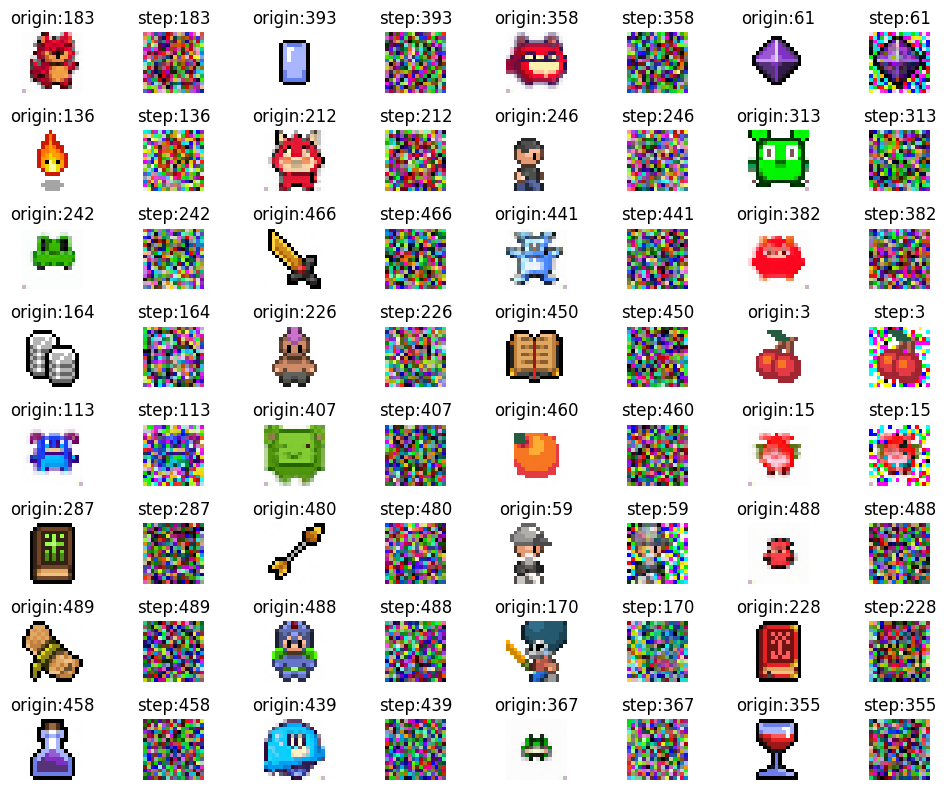

In [10]:
sample, sample_noise = list(sample)[0]
sample_t, sample_X = sample['time'], sample['X_noisy']
# there is value < -1.0 and > 1.0. clipping is required to recover.



def normal_to_image(X):
    return tf.clip_by_value(tf.cast((X + 1.0) / 2.0 * 255.0, dtype=tf.uint8), 0, 255)

def substract_noise(X_noisy, t, noise):
    _, alpha_overline, _ = variance_schedule(T)
    X_shape = tf.shape(X_noisy)
    alpha_o = tf.cast(tf.gather(alpha_overline, t), dtype=tf.float32)
    alpha_o = tf.reshape(alpha_o, [X_shape[0]] + [1] * (len(X_shape)-1))
    
    # reverse of (alpha_o ** 0.5) * X + ((1 - alpha_o) ** 0.5) * noise
    return (X_noisy - ((1 - alpha_o) ** 0.5) * noise) / (alpha_o ** 0.5)

recovered_images = substract_noise(sample_X, sample_t, sample_noise)

fig, axs = plt.subplots(8, 8, figsize=[10,8])
for i in range(len(sample_t[:32])):
    image = normal_to_image(sample_X[i])
    recovered_image = normal_to_image(recovered_images[i])
    
    # print(recovered_image)
    axs[(2*i) // 8, (2*i) % 8].imshow(recovered_image)
    axs[(2*i) // 8, (2*i) % 8].set_title(f'origin:{tf.keras.backend.get_value(sample_t[i])}')
    axs[(2*i) // 8, (2*i) % 8].axis('off')

    axs[(2*i) // 8, (2*i) % 8 + 1].imshow(image)
    axs[(2*i) // 8, (2*i) % 8 + 1].set_title(f'step:{tf.keras.backend.get_value(sample_t[i])}')
    axs[(2*i) // 8, (2*i) % 8 + 1].axis('off')
    

plt.tight_layout()


In [11]:
class TimeEncoding(tl.Layer):
    def __init__(self, T, embed_size, dtype=tf.float32, **kwargs):
        super().__init__(dtype=dtype, **kwargs)
        assert embed_size % 2 ==0, 'embed size must be even number'
        p, i = np.meshgrid(np.arange(T+1), 2 * np.arange(embed_size // 2))
        pos_emb = np.empty((T+1, embed_size)) # T X d_emb 
        pos_emb[:, ::2] = np.sin(p / (10_000 ** (i / embed_size))).T
        pos_emb[:, 1::2] = np.cos(p / (10_000 ** (i / embed_size))).T
        self.time_encodings = tf.constant(pos_emb.astype(self.dtype)) # numpy.empty는 기본적으로 float64로 만들기 때문에 float32 이하를 tensorflow에서 사용하기 위해서는 type 변경이 필오하다.
        # self.supports_masking = True # mask propabation for next layer

    def call(self, inputs):
        return tf.gather(self.time_encodings, inputs) # shape: (batch, d_emb)


In [12]:
def residual_block(Z, dim):
    Z = tl.Conv2D(dim, 3, padding='same')(Z)
    Z = tl.BatchNormalization()(Z)
    Z = tl.Activation('relu')(Z)

    Z = tl.Conv2D(dim, 3, padding='same')(Z)
    Z = tl.BatchNormalization()(Z)
    Z = tl.Activation('relu')(Z)

    return Z

def time_block(time_enc, dim):
    time_Z = tl.Dense(dim)(time_enc)
    time_Z = tl.Activation('relu')(time_Z)
    time_Z = tl.Dense(dim)(time_Z)
    
    return time_Z


def down(Z, dim):
    Z = residual_block(Z, dim)
    Z = residual_block(Z, dim)
    Z = tl.MaxPooling2D(3, strides=2, padding='same')(Z)
    skip = Z
    return Z, skip

def up(Z, dim):
    Z = tl.Conv2DTranspose(dim, 3, padding='same')(Z)
    Z = tl.BatchNormalization()(Z)
    Z = tl.Activation('relu')(Z)

    Z = residual_block(Z, dim)
    Z = residual_block(Z, dim)

    Z = tl.UpSampling2D(2)(Z) # 2x W, H with repeat value

    return Z


def build_diffusion_model(input_shape, T, embed_size):
    X_noisy = tl.Input(shape=input_shape, name='X_noisy')
    time_input = tl.Input(shape=[], dtype=tf.int32, name='time')
    time_enc = TimeEncoding(T, embed_size)(time_input) # batch_size X embed_size

    dim = 64
    down0 = residual_block(X_noisy, dim)
    Z = down0

    dim = 64
    Z, down1 = down(Z, dim) # down1: batch X 8 X 8 X 64
    dim = 128
    Z, down2 = down(Z, dim) # down2: batch X 4 X 4 X 128

    # bottom layer
    Z = tl.Conv2DTranspose(dim, 3, padding='same')(Z)
    Z = tl.BatchNormalization()(Z)
    Z = tl.Activation('relu')(Z)


    # up 1
    time_Z = time_block(time_enc, dim)
    Z = time_Z[:, tf.newaxis, tf.newaxis, :] + Z # C: 128
    
    Z = tl.concatenate([Z, down2], axis=-1) # C: 256

    dim = 64
    Z = up(Z, dim)

    # up 2
    time_Z = time_block(time_enc, dim)
    Z = time_Z[:, tf.newaxis, tf.newaxis, :] + Z
    Z = tl.concatenate([Z, down1], axis=-1)
    
    dim = 64
    Z = up(Z, dim)

    # final
    Z = tl.concatenate([Z, down0], axis=-1)
    Z = residual_block(Z, dim)
    output = tl.Conv2D(3, 3, padding='same')(Z)

    return tf.keras.Model(inputs=[X_noisy, time_input], outputs=[output])
    
    

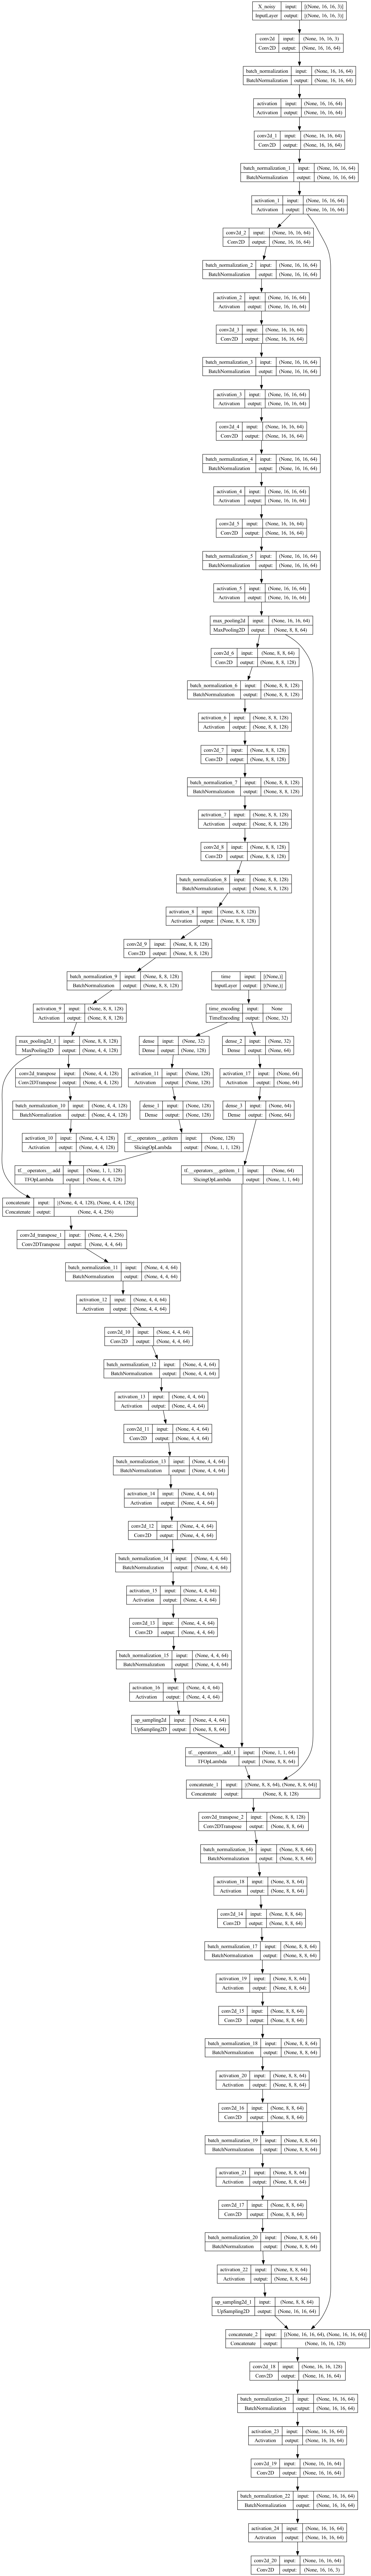

In [13]:
model = build_diffusion_model([16, 16, 3], T, 32)
from tensorflow.keras.utils import plot_model

plot_model(model, to_file='diffusion_mode.png', show_shapes=True, show_layer_names=True)

In [14]:

def lr_scheduler_factory(n_epoch, initial_lr):
    def lr_scheduler(epoch, lr):
        try:
            print(f'previous learning rate: {lr}')
            # if epoch:
            #     decay_rate = 0.95
            # else:
            #     decay_rate = 1.00
            lr = initial_lr * (1.0-((1.0 * epoch/n_epoch) ** 2.0))
            # lr *= decay_rate
            print(f'learning rate: {lr} at epoch {epoch}')
        except Exception as e:
            print(e)
        return lr
    return lr_scheduler



In [15]:
# initial_learning_rate = 0.002
# lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate,
#     decay_steps=1250,
#     decay_rate=0.96,
#     staircase=True)

In [16]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 9234820769339803984
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
locality {
  bus_id: 1
}
incarnation: 9725442788222797398
physical_device_desc: "device: 0, name: METAL, pci bus id: <undefined>"
xla_global_id: -1
]


2024-01-12 22:10:46.765689: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-01-12 22:10:46.765714: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [17]:
file_path = Path('models/diffusion_model/model_32.h5')

if file_path.is_file():
    model = tf.keras.models.load_model(file_path, custom_objects={'TimeEncoding': TimeEncoding})
else:
    epochs = 32
    initial_lr = 0.001
    checkpoint_cb = tf.keras.callbacks.ModelCheckpoint('checkpoints/diffusion_model', save_best_only=True)
    lr_scheduler_cb = tf.keras.callbacks.LearningRateScheduler(lr_scheduler_factory(epochs, initial_lr))
    optimizer = tf.keras.optimizers.legacy.Nadam(learning_rate=initial_lr)
    model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=optimizer)
    with tf.device('/cpu:0'):
        history = model.fit(train_set, validation_data=valid_set, epochs=epochs, callbacks=[checkpoint_cb, lr_scheduler_cb])
    Path('models/diffusion_model').mkdir(parents=True, exist_ok=True)
    model.save('models/diffusion_model/model_32.h5')

previous learning rate: 0.0010000000474974513
learning rate: 0.001 at epoch 0
Epoch 1/32


2024-01-12 22:10:59.739968: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


1335/1335 [==============================] - ETA: 0s - loss: 0.2125INFO:tensorflow:Assets written to: checkpoints/diffusion_model/assets


INFO:tensorflow:Assets written to: checkpoints/diffusion_model/assets


1335/1335 [==============================] - 363s 268ms/step - loss: 0.2125 - val_loss: 0.1952 - lr: 0.0010
previous learning rate: 0.0010000000474974513
learning rate: 0.0009990234375000001 at epoch 1
Epoch 2/32
1335/1335 [==============================] - ETA: 0s - loss: 0.1426INFO:tensorflow:Assets written to: checkpoints/diffusion_model/assets


INFO:tensorflow:Assets written to: checkpoints/diffusion_model/assets


1335/1335 [==============================] - 375s 281ms/step - loss: 0.1426 - val_loss: 0.1449 - lr: 9.9902e-04
previous learning rate: 0.0009990234393626451
learning rate: 0.00099609375 at epoch 2
Epoch 3/32
1335/1335 [==============================] - ETA: 0s - loss: 0.1232INFO:tensorflow:Assets written to: checkpoints/diffusion_model/assets


INFO:tensorflow:Assets written to: checkpoints/diffusion_model/assets


1335/1335 [==============================] - 368s 275ms/step - loss: 0.1232 - val_loss: 0.1290 - lr: 9.9609e-04
previous learning rate: 0.0009960937313735485
learning rate: 0.0009912109375000001 at epoch 3
Epoch 4/32
1335/1335 [==============================] - ETA: 0s - loss: 0.1116INFO:tensorflow:Assets written to: checkpoints/diffusion_model/assets


INFO:tensorflow:Assets written to: checkpoints/diffusion_model/assets


1335/1335 [==============================] - 371s 278ms/step - loss: 0.1116 - val_loss: 0.1202 - lr: 9.9121e-04
previous learning rate: 0.0009912109235301614
learning rate: 0.000984375 at epoch 4
Epoch 5/32
1335/1335 [==============================] - ETA: 0s - loss: 0.1034INFO:tensorflow:Assets written to: checkpoints/diffusion_model/assets


INFO:tensorflow:Assets written to: checkpoints/diffusion_model/assets


1335/1335 [==============================] - 368s 275ms/step - loss: 0.1034 - val_loss: 0.1033 - lr: 9.8438e-04
previous learning rate: 0.0009843750158324838
learning rate: 0.0009755859375 at epoch 5
Epoch 6/32
1335/1335 [==============================] - ETA: 0s - loss: 0.0977INFO:tensorflow:Assets written to: checkpoints/diffusion_model/assets


INFO:tensorflow:Assets written to: checkpoints/diffusion_model/assets


1335/1335 [==============================] - 363s 272ms/step - loss: 0.0977 - val_loss: 0.0961 - lr: 9.7559e-04
previous learning rate: 0.0009755859500728548
learning rate: 0.00096484375 at epoch 6
Epoch 7/32
1335/1335 [==============================] - ETA: 0s - loss: 0.0930INFO:tensorflow:Assets written to: checkpoints/diffusion_model/assets


INFO:tensorflow:Assets written to: checkpoints/diffusion_model/assets


1335/1335 [==============================] - 368s 275ms/step - loss: 0.0930 - val_loss: 0.0947 - lr: 9.6484e-04
previous learning rate: 0.0009648437262512743
learning rate: 0.0009521484375 at epoch 7
Epoch 8/32
1335/1335 [==============================] - ETA: 0s - loss: 0.0890INFO:tensorflow:Assets written to: checkpoints/diffusion_model/assets


INFO:tensorflow:Assets written to: checkpoints/diffusion_model/assets


1335/1335 [==============================] - 363s 272ms/step - loss: 0.0890 - val_loss: 0.0871 - lr: 9.5215e-04
previous learning rate: 0.0009521484607830644
learning rate: 0.0009375 at epoch 8
Epoch 9/32
1335/1335 [==============================] - ETA: 0s - loss: 0.0860INFO:tensorflow:Assets written to: checkpoints/diffusion_model/assets


INFO:tensorflow:Assets written to: checkpoints/diffusion_model/assets


1335/1335 [==============================] - 362s 271ms/step - loss: 0.0860 - val_loss: 0.0837 - lr: 9.3750e-04
previous learning rate: 0.0009374999790452421
learning rate: 0.0009208984375000001 at epoch 9
Epoch 10/32
1335/1335 [==============================] - ETA: 0s - loss: 0.0832INFO:tensorflow:Assets written to: checkpoints/diffusion_model/assets


INFO:tensorflow:Assets written to: checkpoints/diffusion_model/assets


1335/1335 [==============================] - 367s 275ms/step - loss: 0.0832 - val_loss: 0.0781 - lr: 9.2090e-04
previous learning rate: 0.0009208984556607902
learning rate: 0.00090234375 at epoch 10
Epoch 11/32
1335/1335 [==============================] - ETA: 0s - loss: 0.0809INFO:tensorflow:Assets written to: checkpoints/diffusion_model/assets


INFO:tensorflow:Assets written to: checkpoints/diffusion_model/assets


1335/1335 [==============================] - 374s 280ms/step - loss: 0.0809 - val_loss: 0.0781 - lr: 9.0234e-04
previous learning rate: 0.0009023437742143869
learning rate: 0.0008818359375 at epoch 11
Epoch 12/32
1335/1335 [==============================] - ETA: 0s - loss: 0.0786INFO:tensorflow:Assets written to: checkpoints/diffusion_model/assets


INFO:tensorflow:Assets written to: checkpoints/diffusion_model/assets


1335/1335 [==============================] - 371s 278ms/step - loss: 0.0786 - val_loss: 0.0763 - lr: 8.8184e-04
previous learning rate: 0.0008818359347060323
learning rate: 0.000859375 at epoch 12
Epoch 13/32
1335/1335 [==============================] - ETA: 0s - loss: 0.0770INFO:tensorflow:Assets written to: checkpoints/diffusion_model/assets


INFO:tensorflow:Assets written to: checkpoints/diffusion_model/assets


1335/1335 [==============================] - 368s 276ms/step - loss: 0.0770 - val_loss: 0.0762 - lr: 8.5937e-04
previous learning rate: 0.0008593749953433871
learning rate: 0.0008349609375 at epoch 13
Epoch 14/32
1335/1335 [==============================] - ETA: 0s - loss: 0.0748INFO:tensorflow:Assets written to: checkpoints/diffusion_model/assets


INFO:tensorflow:Assets written to: checkpoints/diffusion_model/assets


1335/1335 [==============================] - 378s 283ms/step - loss: 0.0748 - val_loss: 0.0718 - lr: 8.3496e-04
previous learning rate: 0.0008349609561264515
learning rate: 0.0008085937500000001 at epoch 14
Epoch 15/32
1335/1335 [==============================] - ETA: 0s - loss: 0.0733INFO:tensorflow:Assets written to: checkpoints/diffusion_model/assets


INFO:tensorflow:Assets written to: checkpoints/diffusion_model/assets


1335/1335 [==============================] - 378s 283ms/step - loss: 0.0733 - val_loss: 0.0707 - lr: 8.0859e-04
previous learning rate: 0.0008085937588475645
learning rate: 0.0007802734375 at epoch 15
Epoch 16/32
1335/1335 [==============================] - ETA: 0s - loss: 0.0715INFO:tensorflow:Assets written to: checkpoints/diffusion_model/assets


INFO:tensorflow:Assets written to: checkpoints/diffusion_model/assets


1335/1335 [==============================] - 384s 288ms/step - loss: 0.0715 - val_loss: 0.0674 - lr: 7.8027e-04
previous learning rate: 0.0007802734617143869
learning rate: 0.00075 at epoch 16
Epoch 17/32
1335/1335 [==============================] - ETA: 0s - loss: 0.0701INFO:tensorflow:Assets written to: checkpoints/diffusion_model/assets


INFO:tensorflow:Assets written to: checkpoints/diffusion_model/assets


1335/1335 [==============================] - 381s 285ms/step - loss: 0.0701 - val_loss: 0.0670 - lr: 7.5000e-04
previous learning rate: 0.000750000006519258
learning rate: 0.0007177734375 at epoch 17
Epoch 18/32
1335/1335 [==============================] - ETA: 0s - loss: 0.0688INFO:tensorflow:Assets written to: checkpoints/diffusion_model/assets


INFO:tensorflow:Assets written to: checkpoints/diffusion_model/assets


1335/1335 [==============================] - 382s 286ms/step - loss: 0.0688 - val_loss: 0.0645 - lr: 7.1777e-04
previous learning rate: 0.0007177734514698386
learning rate: 0.0006835937500000001 at epoch 18
Epoch 19/32
1335/1335 [==============================] - ETA: 0s - loss: 0.0674INFO:tensorflow:Assets written to: checkpoints/diffusion_model/assets


INFO:tensorflow:Assets written to: checkpoints/diffusion_model/assets


1335/1335 [==============================] - 385s 289ms/step - loss: 0.0674 - val_loss: 0.0633 - lr: 6.8359e-04
previous learning rate: 0.0006835937383584678
learning rate: 0.0006474609375 at epoch 19
Epoch 20/32
1335/1335 [==============================] - ETA: 0s - loss: 0.0664INFO:tensorflow:Assets written to: checkpoints/diffusion_model/assets


INFO:tensorflow:Assets written to: checkpoints/diffusion_model/assets


1335/1335 [==============================] - 372s 279ms/step - loss: 0.0664 - val_loss: 0.0609 - lr: 6.4746e-04
previous learning rate: 0.0006474609253928065
learning rate: 0.000609375 at epoch 20
Epoch 21/32
1335/1335 [==============================] - ETA: 0s - loss: 0.0648INFO:tensorflow:Assets written to: checkpoints/diffusion_model/assets


INFO:tensorflow:Assets written to: checkpoints/diffusion_model/assets


1335/1335 [==============================] - 369s 277ms/step - loss: 0.0648 - val_loss: 0.0604 - lr: 6.0938e-04
previous learning rate: 0.0006093750125728548
learning rate: 0.0005693359375 at epoch 21
Epoch 22/32
1335/1335 [==============================] - ETA: 0s - loss: 0.0640INFO:tensorflow:Assets written to: checkpoints/diffusion_model/assets


INFO:tensorflow:Assets written to: checkpoints/diffusion_model/assets


1335/1335 [==============================] - 372s 278ms/step - loss: 0.0640 - val_loss: 0.0595 - lr: 5.6934e-04
previous learning rate: 0.0005693359416909516
learning rate: 0.00052734375 at epoch 22
Epoch 23/32
1335/1335 [==============================] - ETA: 0s - loss: 0.0628INFO:tensorflow:Assets written to: checkpoints/diffusion_model/assets


INFO:tensorflow:Assets written to: checkpoints/diffusion_model/assets


1335/1335 [==============================] - 371s 278ms/step - loss: 0.0628 - val_loss: 0.0582 - lr: 5.2734e-04
previous learning rate: 0.0005273437709547579
learning rate: 0.0004833984375 at epoch 23
Epoch 24/32
1335/1335 [==============================] - ETA: 0s - loss: 0.0616INFO:tensorflow:Assets written to: checkpoints/diffusion_model/assets


INFO:tensorflow:Assets written to: checkpoints/diffusion_model/assets


1335/1335 [==============================] - 373s 280ms/step - loss: 0.0616 - val_loss: 0.0575 - lr: 4.8340e-04
previous learning rate: 0.0004833984421566129
learning rate: 0.0004375 at epoch 24
Epoch 25/32
1335/1335 [==============================] - ETA: 0s - loss: 0.0605INFO:tensorflow:Assets written to: checkpoints/diffusion_model/assets


INFO:tensorflow:Assets written to: checkpoints/diffusion_model/assets


1335/1335 [==============================] - 368s 276ms/step - loss: 0.0605 - val_loss: 0.0569 - lr: 4.3750e-04
previous learning rate: 0.00043750001350417733
learning rate: 0.0003896484375 at epoch 25
Epoch 26/32
1335/1335 [==============================] - ETA: 0s - loss: 0.0595INFO:tensorflow:Assets written to: checkpoints/diffusion_model/assets


INFO:tensorflow:Assets written to: checkpoints/diffusion_model/assets


1335/1335 [==============================] - 371s 278ms/step - loss: 0.0595 - val_loss: 0.0551 - lr: 3.8965e-04
previous learning rate: 0.0003896484267897904
learning rate: 0.00033984375000000003 at epoch 26
Epoch 27/32
1335/1335 [==============================] - ETA: 0s - loss: 0.0585INFO:tensorflow:Assets written to: checkpoints/diffusion_model/assets


INFO:tensorflow:Assets written to: checkpoints/diffusion_model/assets


1335/1335 [==============================] - 377s 282ms/step - loss: 0.0585 - val_loss: 0.0532 - lr: 3.3984e-04
previous learning rate: 0.00033984374022111297
learning rate: 0.0002880859375 at epoch 27
Epoch 28/32
1335/1335 [==============================] - ETA: 0s - loss: 0.0573INFO:tensorflow:Assets written to: checkpoints/diffusion_model/assets


INFO:tensorflow:Assets written to: checkpoints/diffusion_model/assets


1335/1335 [==============================] - 376s 282ms/step - loss: 0.0573 - val_loss: 0.0527 - lr: 2.8809e-04
previous learning rate: 0.0002880859246943146
learning rate: 0.000234375 at epoch 28
Epoch 29/32
1335/1335 [==============================] - ETA: 0s - loss: 0.0564INFO:tensorflow:Assets written to: checkpoints/diffusion_model/assets


INFO:tensorflow:Assets written to: checkpoints/diffusion_model/assets


1335/1335 [==============================] - 373s 279ms/step - loss: 0.0564 - val_loss: 0.0516 - lr: 2.3437e-04
previous learning rate: 0.00023437499476131052
learning rate: 0.0001787109375 at epoch 29
Epoch 30/32
1335/1335 [==============================] - ETA: 0s - loss: 0.0554INFO:tensorflow:Assets written to: checkpoints/diffusion_model/assets


INFO:tensorflow:Assets written to: checkpoints/diffusion_model/assets


1335/1335 [==============================] - 382s 286ms/step - loss: 0.0554 - val_loss: 0.0504 - lr: 1.7871e-04
previous learning rate: 0.0001787109358701855
learning rate: 0.00012109375 at epoch 30
Epoch 31/32
1335/1335 [==============================] - ETA: 0s - loss: 0.0546INFO:tensorflow:Assets written to: checkpoints/diffusion_model/assets


INFO:tensorflow:Assets written to: checkpoints/diffusion_model/assets


1335/1335 [==============================] - 390s 292ms/step - loss: 0.0546 - val_loss: 0.0495 - lr: 1.2109e-04
previous learning rate: 0.00012109374802093953
learning rate: 6.15234375e-05 at epoch 31
Epoch 32/32
1335/1335 [==============================] - ETA: 0s - loss: 0.0537INFO:tensorflow:Assets written to: checkpoints/diffusion_model/assets


INFO:tensorflow:Assets written to: checkpoints/diffusion_model/assets


1335/1335 [==============================] - 385s 288ms/step - loss: 0.0537 - val_loss: 0.0485 - lr: 6.1523e-05


/Users/yunhongmin/.pyenv/versions/3.10.13/envs/machine-learning-practice-3.10.13/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [31]:
file_path = Path('models/diffusion_model/model_50.h5')

if file_path.is_file():
    model = tf.keras.models.load_model(file_path, custom_objects={'TimeEncoding': TimeEncoding})
else:
    epochs = 14
    initial_lr = 0.0001
    checkpoint_cb = tf.keras.callbacks.ModelCheckpoint('checkpoints/diffusion_model', save_best_only=True)
    lr_scheduler_cb = tf.keras.callbacks.LearningRateScheduler(lr_scheduler_factory(epochs, initial_lr))
    optimizer = tf.keras.optimizers.legacy.Nadam(learning_rate=initial_lr)
    model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=optimizer)
    with tf.device('/cpu:0'):
        history = model.fit(train_set, validation_data=valid_set, epochs=epochs, callbacks=[checkpoint_cb, lr_scheduler_cb])
    Path('models/diffusion_model').mkdir(parents=True, exist_ok=True)
    model.save('models/diffusion_model/model_50.h5')

In [40]:
file_path = Path('models/diffusion_model/model_80.h5')

if file_path.is_file():
    model = tf.keras.models.load_model(file_path, custom_objects={'TimeEncoding': TimeEncoding})
else:
    epochs = 10
    initial_lr = 0.000001
    checkpoint_cb = tf.keras.callbacks.ModelCheckpoint('checkpoints/diffusion_model', save_best_only=True)
    lr_scheduler_cb = tf.keras.callbacks.LearningRateScheduler(lr_scheduler_factory(epochs, initial_lr))
    optimizer = tf.keras.optimizers.legacy.Nadam(learning_rate=initial_lr)
    model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=optimizer)
    with tf.device('/cpu:0'):
        history = model.fit(train_set, validation_data=valid_set, epochs=epochs, callbacks=[checkpoint_cb, lr_scheduler_cb])
    Path('models/diffusion_model').mkdir(parents=True, exist_ok=True)
    model.save('models/diffusion_model/model_80.h5')

previous learning rate: 9.999999974752427e-07
learning rate: 1e-06 at epoch 0
Epoch 1/10
1335/1335 [==============================] - ETA: 0s - loss: 0.0478INFO:tensorflow:Assets written to: checkpoints/diffusion_model/assets


INFO:tensorflow:Assets written to: checkpoints/diffusion_model/assets


1335/1335 [==============================] - 401s 294ms/step - loss: 0.0478 - val_loss: 0.0426 - lr: 1.0000e-06
previous learning rate: 9.999999974752427e-07
learning rate: 9.9e-07 at epoch 1
Epoch 2/10
1335/1335 [==============================] - ETA: 0s - loss: 0.0478INFO:tensorflow:Assets written to: checkpoints/diffusion_model/assets


INFO:tensorflow:Assets written to: checkpoints/diffusion_model/assets


1335/1335 [==============================] - 386s 289ms/step - loss: 0.0478 - val_loss: 0.0426 - lr: 9.9000e-07
previous learning rate: 9.899999895424116e-07
learning rate: 9.6e-07 at epoch 2
Epoch 3/10
1335/1335 [==============================] - 377s 282ms/step - loss: 0.0479 - val_loss: 0.0426 - lr: 9.6000e-07
previous learning rate: 9.599999657439184e-07
learning rate: 9.1e-07 at epoch 3
Epoch 4/10
1335/1335 [==============================] - ETA: 0s - loss: 0.0478INFO:tensorflow:Assets written to: checkpoints/diffusion_model/assets


INFO:tensorflow:Assets written to: checkpoints/diffusion_model/assets


1335/1335 [==============================] - 397s 298ms/step - loss: 0.0478 - val_loss: 0.0426 - lr: 9.1000e-07
previous learning rate: 9.09999982923182e-07
learning rate: 8.399999999999999e-07 at epoch 4
Epoch 5/10
1335/1335 [==============================] - ETA: 0s - loss: 0.0479INFO:tensorflow:Assets written to: checkpoints/diffusion_model/assets


INFO:tensorflow:Assets written to: checkpoints/diffusion_model/assets


1335/1335 [==============================] - 396s 297ms/step - loss: 0.0479 - val_loss: 0.0426 - lr: 8.4000e-07
previous learning rate: 8.399999842367833e-07
learning rate: 7.5e-07 at epoch 5
Epoch 6/10
1335/1335 [==============================] - ETA: 0s - loss: 0.0480INFO:tensorflow:Assets written to: checkpoints/diffusion_model/assets


INFO:tensorflow:Assets written to: checkpoints/diffusion_model/assets


1335/1335 [==============================] - 387s 290ms/step - loss: 0.0480 - val_loss: 0.0426 - lr: 7.5000e-07
previous learning rate: 7.500000265281415e-07
learning rate: 6.4e-07 at epoch 6
Epoch 7/10
1335/1335 [==============================] - 384s 288ms/step - loss: 0.0478 - val_loss: 0.0426 - lr: 6.4000e-07
previous learning rate: 6.399999961104186e-07
learning rate: 5.1e-07 at epoch 7
Epoch 8/10
1335/1335 [==============================] - 381s 285ms/step - loss: 0.0479 - val_loss: 0.0426 - lr: 5.1000e-07
previous learning rate: 5.100000066704524e-07
learning rate: 3.5999999999999984e-07 at epoch 8
Epoch 9/10
1335/1335 [==============================] - 383s 287ms/step - loss: 0.0478 - val_loss: 0.0426 - lr: 3.6000e-07
previous learning rate: 3.6000000136482413e-07
learning rate: 1.8999999999999993e-07 at epoch 9
Epoch 10/10
1335/1335 [==============================] - 2106s 2s/step - loss: 0.0477 - val_loss: 0.0426 - lr: 1.9000e-07


/Users/yunhongmin/.pyenv/versions/3.10.13/envs/machine-learning-practice-3.10.13/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [49]:
def generate(model, T, batch_size=32):
    alpha, alpha_overline, beta = variance_schedule(T)
    X = tf.random.normal([batch_size, 16, 16, 3])
    for t in range(T - 1, 0, -1):
        print(f"\rt = {t}", end=" ")  # 추가 코드 - 진행률 표시
        noise = (tf.random.normal if t > 1 else tf.zeros)(tf.shape(X))
        X_noise = model({"X_noisy": X, "time": tf.constant([t] * batch_size)})
        # X = (X - (beta[t] ** 0.5) * X_noise) / (alpha[t] ** 0.5)
        X = (
            1 / (alpha[t] ** 0.5)
            * (X - beta[t] / ((1 - alpha_overline[t]) ** 0.5) * X_noise)
            + (1 - alpha[t]) ** 0.5 * noise
        )
    return X

In [50]:
tf.random.set_seed(42)
X_created = generate(model, T)

t = 1   

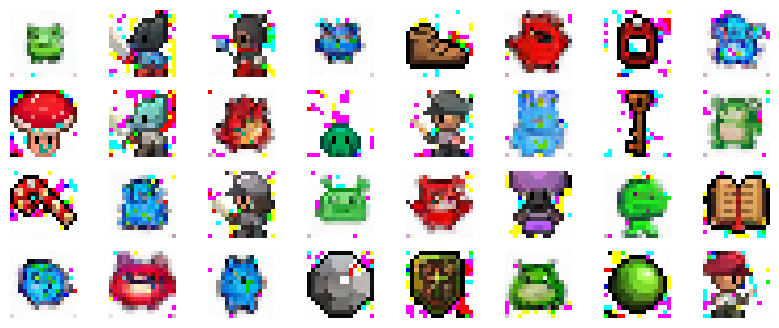

In [51]:
fig, axs = plt.subplots(4, 8, figsize=[10,4])
for i in range(len(X_created)):
    image = normal_to_image(X_created[i])

    axs[i // 8, i % 8].imshow(image)
    axs[i // 8, i % 8].axis('off')